In [1]:
from Propagation_functions import *

# Slits

This part of code treats slits as spatial masks that are multiplied to the field magnitude. Then the diffraction result is simply calculated as the free space propagation of the masked beam.

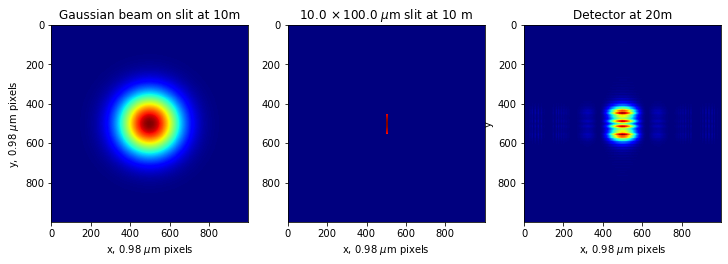

In [2]:
# Gaussian beam, 10m slit, 20m detector
''' Parameters '''
# Gaussian beam
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

w0x = 2e-6
w0y = 2e-6
N = 1000

# slit
slit_z = 10
slit_x = 1e1    # um
slit_y = 1e2    # um

# detector
det_z = 20

''' Propagation '''
beam_gaus,x,y = Gaussian_source(E,w0x,w0y,N,slit_z)
beam_slit = Slit(beam_gaus,x,y,slit_x,slit_y)
beam_det = Drift(beam_slit,x,y,wavelength,det_z-slit_z)

''' Plot '''
dx = x[0,1] - x[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_gaus),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Gaussian beam on slit at {}m'.format(slit_z))

plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_slit),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title(r'{}$\,\times${} $\mu$m slit at {} m'.format(slit_x,slit_y,slit_z))

# plot drift
plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Detector at {}m'.format(det_z))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.savefig('Gaussian_Beam_and_Slit_{}-{}.png'.format(slit_z,det_z),transparent=True)

# Lenses

At first I was trying to simulate lenses as spatial phase delay matrices that are multiplied to the field magnitude, and then propagate the result in freespace to simulate the result at focal plane. However, this method behaves very weirdly for larger lens apertures and I'm assuming that's because of numerical error (not sure).

After trying to fix it for a few days, I decided to analytically solve the diffraction pattern at the focal plane and this approach so far seems to be working properly (see code below). However, this approach only works at the focal plane under thin lens and  paraxial approximations. I guess to calculate the result at arbitrary spatial locations, we still need to figure out how to fix approach 1. But for now I'm happy with moving on to other parts of the simulation and come back to this when I get stuck doing something else again.

lens aperture smaller than beam


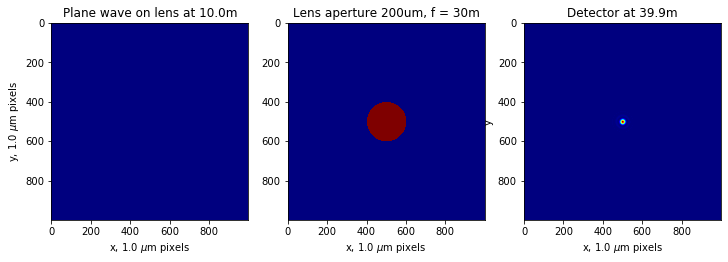

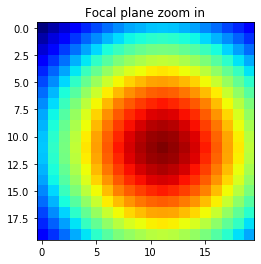

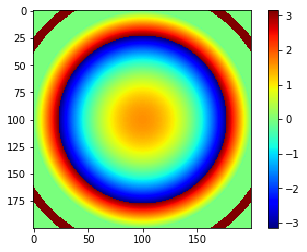

In [3]:
# lens as phase shifter
''' Plane wave '''
def Lens_phase(beam,x,y,k,r,f):
    window = window = np.square(x)+np.square(y)<np.square(r/1e6)
    if window.sum() <= window.size:
        print('lens aperture smaller than beam')
    transmission = np.exp(-1j * k/2/f * (np.square(x)+np.square(y)))
    beam_lens = beam*window*transmission
    return beam_lens

''' Parameters '''
# Plane wave
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

# lens
lens_z = 10.
r = 100       # um
f = 30

# detector
det_z = lens_z+f-0.1

''' Propagation '''
beam_plane,x,y = Plane_source(E,lens_z)
beam_lens = Lens_phase(beam_plane,x,y,k,r,f)
beam_det = Drift(beam_lens,x,y,wavelength,det_z-lens_z)

''' Plot '''
dx = x[0,1] - x[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_plane),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Plane wave on lens at {}m'.format(lens_z))

plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_lens),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title(r'Lens aperture {}um, f = {}m'.format(r*2,f))

# plot drift
plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Detector at {}m'.format(round(det_z,4)))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))

plt.figure()
plt.imshow(Ibeam(beam_det)[490:510,490:510],cmap='jet')
plt.title('Focal plane zoom in')

plt.figure()
plt.imshow(np.angle(beam_lens)[400:600,400:600],cmap='jet')
plt.colorbar()

lens aperture smaller than beam


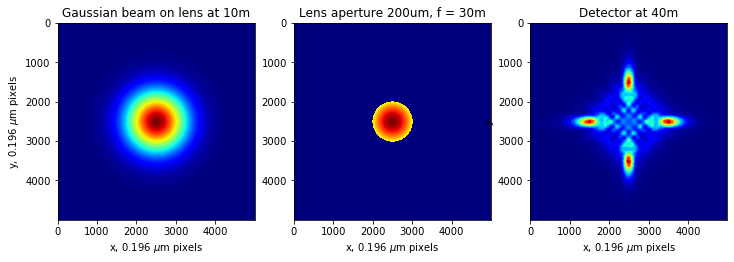

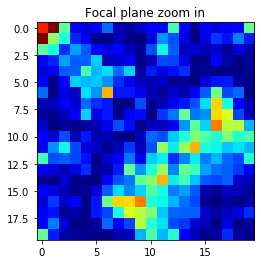

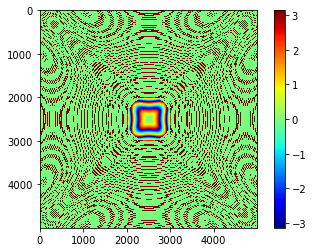

In [4]:
# lens as phase shifter
''' Gaussian beam '''

''' Parameters '''
# Gaussian beam
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

w0x = 2e-6
w0y = 2e-6
N = 5000

# lens
lens_z = 10
r = 100      # um
f = 30

# detector
det_z = lens_z+f


''' Propagation '''
beam_gaus,x,y = Gaussian_source(E,w0x,w0y,N,lens_z)
beam_lens = Lens_phase(beam_gaus,x,y,k,r,f)
beam_det = Drift(beam_lens,x,y,wavelength,det_z-lens_z)

''' Plot '''
dx = x[0,1] - x[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_gaus),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Gaussian beam on lens at {}m'.format(lens_z))

plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_lens),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title(r'Lens aperture {}um, f = {}m'.format(r*2,f))

# plot drift
plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Detector at {}m'.format(round(det_z,4)))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))

plt.figure()
plt.imshow(Ibeam(beam_det)[490:510,490:510],cmap='jet')
plt.title('Focal plane zoom in')

plt.figure()
plt.imshow(np.angle(beam_lens),cmap='jet')
plt.colorbar()

lens aperture smaller than beam


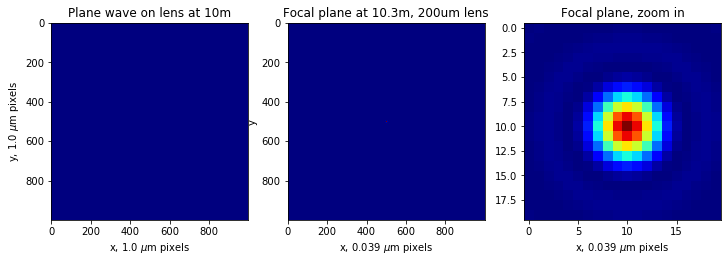

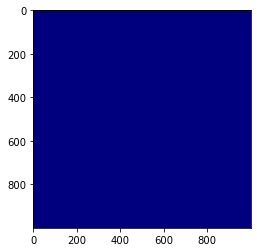

In [5]:
# Plane wave, 10m lens, focal plane detector
''' Parameters '''
# Plane wave
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

# lens
lens_z = 10
r = 100       # um
f = 0.3

# detector
det_z = lens_z+f

''' Propagation '''
beam_plane,x,y = Plane_source(E,lens_z)
beam_det,x1,y1 = Lens(beam_plane,x,y,k,r,f)
#beam_det = Drift(beam_lens,x1,y1,wavelength,det_z-lens_z)

''' Plot '''
dx = x[0,1] - x[0,0]
dx1 = x1[0,1] - x1[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_plane),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Plane wave on lens at {}m'.format(lens_z))

# plot drift
plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Focal plane at {}m, {}um lens'.format(det_z,r*2))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx1*1e6,3)))
#plt.savefig('Plane_wave_and_lens_{}-{}.png'.format(lens_z,det_z),transparent=True)

plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det)[490:510,490:510],cmap='jet')
plt.title('Focal plane, zoom in')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx1*1e6,3)))

plt.figure()
plt.imshow(beam_plane.real,cmap='jet')

For Gaussian beam, the diffraction pattern looks kind of weird once lens aperture becomes large. I'm not sure whether it is supposed to look like this.

lens aperture smaller than beam


Text(0.5, 0, 'x, 0.288 $\\mu$m pixels')

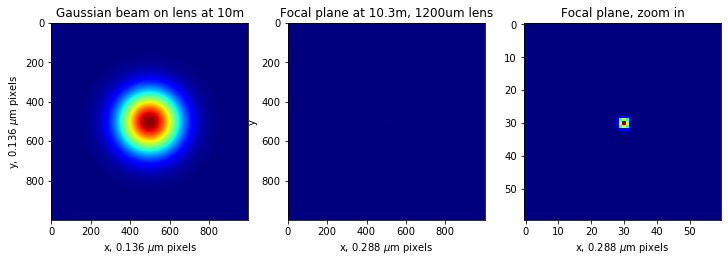

In [9]:
# Gaussian beam, 10m lens, focal plane detector
''' Parameters '''
# Gaussian beam
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

w0x = 20e-6
w0y = 20e-6
N = 1000

# lens
lens_z = 10
r = 600       # um
f = 0.3

# detector
det_z = lens_z+f

''' Propagation '''
beam_gaus,x,y = Gaussian_source(E,w0x,w0y,N,lens_z)
beam_det,x1,y1 = Lens(beam_gaus,x,y,k,r,f)

''' Plot '''
dx = x[0,1] - x[0,0]
dx1 = x1[0,1] - x1[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_gaus),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Gaussian beam on lens at {}m'.format(lens_z))


# plot drift
plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Focal plane at {}m, {}um lens'.format(det_z,r*2))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx1*1e6,3)))
#plt.savefig('Gaussian_Beam_and_lens_{}-{}.png'.format(lens_z,det_z),transparent=True)

plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det)[470:530,470:530],cmap='jet')
plt.title('Focal plane, zoom in')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx1*1e6,3)))

# Alternative approach
This approach attempts to directly calculate the new beam axis and the beam profile at focus. This way I may be able to avoid the delicate phase treatments for larger divergence beams. Still a work in progress.

Text(0.5, 0, 'x, 0.039 $\\mu$m pixels')

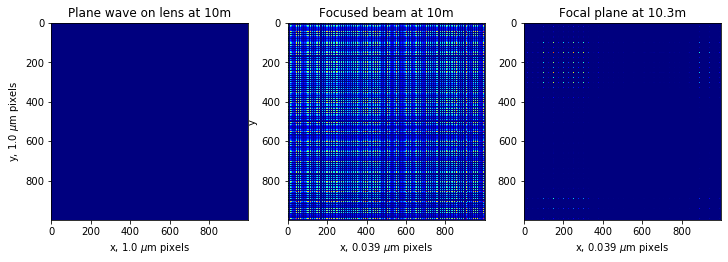

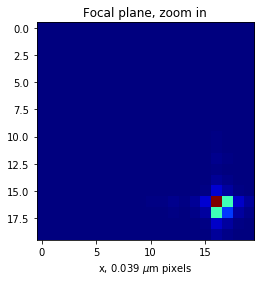

In [7]:
# by calculating new axis and new phase
''' Parameters '''
# Plane wave
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

# lens
lens_z = 10
r = 100       # um
f = 0.3

# detector
det_z = lens_z+f

''' Propagation '''
beam_plane,x,y = Plane_source(E,lens_z)
beam_focus,x1,y1,kz1,filter1 = Focus(beam_plane,x,y,wavelength,f)
beam_det = INFFT(NFFT(beam_focus)*np.exp(1j*kz1*f)*filter1)

''' Plot '''
dx = x[0,1] - x[0,0]
dx1 = x1[0,1] - x1[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_plane),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Plane wave on lens at {}m'.format(lens_z))

# plot drift
plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_focus),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Focused beam at {}m'.format(lens_z))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx1*1e6,3)))
#plt.savefig('Plane_wave_and_lens_{}-{}.png'.format(lens_z,det_z),transparent=True)

plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det),cmap='jet')
plt.title('Focal plane at {}m'.format(det_z))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx1*1e6,3)))

plt.figure()
plt.imshow(Ibeam(beam_det)[490:510,490:510],cmap='jet')
plt.title('Focal plane, zoom in')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx1*1e6,3)))


# Mirrors

The code for flat mirrors can be seen in the function.py file. Since the flat mirrors basically just propagates the beam and then flips the wavvector, there's really no point in demonstrating it unless you like seeing three 2D Gaussians sitting there.

On the other hand, the curved mirrors are still a huge pain to work with. I'm still looking at different references to figure out how to efficiently code it up, especially for 2D focusing.

In [8]:
# curved mirrors
''' this is really hard to code up.... '''

' this is really hard to code up.... '